# Bibliotecas

In [1]:
import os
import glob
import shutil
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Arquivos do projeto


In [2]:
# Área de trabalho do projeto
drive.mount('/content/drive')
workspace_path = '/content/drive/MyDrive/Workspace'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Caminho para os arquivos dos dados
data_path = f'{workspace_path}/fiap/pos-tech/data-analytics/fase-4/dados'

In [4]:
# Pasta temporária
temp_path = 'tmp'
os.makedirs(temp_path, exist_ok=True)

In [5]:
# Copiando os arquivos do backup do banco de dados
for part_file in glob.glob(f'{data_path}/anp_dump.tar.gz.part-*'):
    shutil.copy(part_file, temp_path)

In [6]:
# Remontando o arquivo de backup no formato .tar.gz
!cat tmp/anp_dump.tar.gz.part-* > tmp/anp_dump.tar.gz

In [7]:
# Descompactando o arquivo de backup do banco de dados
!tar -xzvf tmp/anp_dump.tar.gz

tmp/anp_dump.backup


# PostgreSQL

In [8]:
# Instalação
!apt-get install -y postgresql

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
postgresql is already the newest version (14+238).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [9]:
# Iniciando o serviço
!service postgresql start

 * Starting PostgreSQL 14 database server
   ...done.


In [10]:
# Configurando o usuário postgres
!sudo -u postgres psql -c "ALTER USER postgres PASSWORD 'postgres';"

ALTER ROLE


In [11]:
# Criando o banco de dados
!sudo -u postgres psql -c "CREATE DATABASE anp;"

ERROR:  database "anp" already exists


In [12]:
# Restaurando os dados para o PostgreSQL
!PGPASSWORD=postgres pg_restore -U postgres -d anp -h localhost -v tmp/anp_dump.backup

pg_restore: connecting to database for restore
pg_restore: creating TABLE "public.preco_combustivel"
pg_restore: while PROCESSING TOC:
pg_restore: from TOC entry 209; 1259 16385 TABLE preco_combustivel postgres
pg_restore: error: could not execute query: ERROR:  relation "preco_combustivel" already exists
Command was: CREATE TABLE public.preco_combustivel (
    regiao_sigla text,
    estado_sigla text,
    municipio text,
    revenda text,
    cnpj_da_revenda text,
    nome_da_rua text,
    numero_rua text,
    complemento text,
    bairro text,
    cep text,
    produto text,
    data_da_coleta date,
    valor_de_venda double precision,
    unidade_de_medida text,
    bandeira text
);


pg_restore: processing data for table "public.preco_combustivel"
pg_restore: warning: errors ignored on restore: 1


# Explorando os dados

In [13]:
# Conexão com o PostgreSQL
conn = psycopg2.connect(
    host='localhost',
    port='5432',
    database='anp',
    user='postgres',
    password='postgres'
)

In [14]:
# Carregando os dados do PostgreSQL em um dataframe Pandas
df = pd.io.sql.read_sql_query("""
  SELECT  regiao_sigla      AS regiao
          , estado_sigla    AS estado
          , municipio
          , bandeira
          , produto
          , valor_de_venda  AS valor_venda
          , data_da_coleta  AS data_coleta
  FROM    public.preco_combustivel
""", conn)

<ipython-input-14-a8c3dfb0f4f5>:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.io.sql.read_sql_query("""


In [15]:
# Ajustando a coluna data_da_coleta
df['data_coleta'] = pd.to_datetime(df['data_coleta'], format='%Y-%m-%d')

# Separando ano e mês
df['ano'] = df['data_coleta'].dt.year
df['mes'] = df['data_coleta'].dt.month

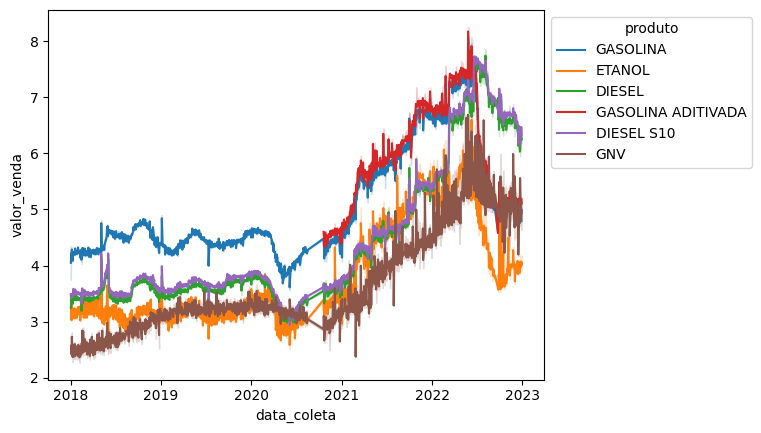

In [16]:
ax = sns.lineplot(data=df, x='data_coleta', y='valor_venda', hue='produto')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [17]:
# Separando os produtos em dataframes
df_diesel_s10 = df[df['produto'] == 'DIESEL S10']
df_diesel = df[df['produto'] == 'DIESEL']
df_etanol = df[df['produto'] == 'ETANOL']
df_gnv = df[df['produto'] == 'GNV']
df_gasolina_c = df[df['produto'] == 'GASOLINA']
df_gasolina_a = df[df['produto'] == 'GASOLINA ADITIVADA']

# Funções para geração de gráficos

In [18]:
def create_boxplot(title, labelx, labely, x, y, dataset):
  sns.set_palette('Accent')
  sns.set_style('darkgrid')
  ax = sns.boxplot(x=x, y=y, data=dataset)
  ax.figure.set_size_inches(12, 6)
  ax.set_title(title, loc='left', fontsize=18)
  ax.set_xlabel(labelx, fontsize=14)
  ax.set_ylabel(labely, fontsize=14)

In [19]:
def create_boxplot_simple(y, dataset):
  ax = sns.boxplot(y=y, data=dataset)
  ax.figure.set_size_inches(4, 4)

# Gráficos

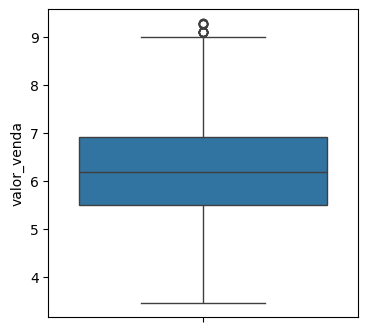

In [20]:
create_boxplot_simple('valor_venda', df_gasolina_a)

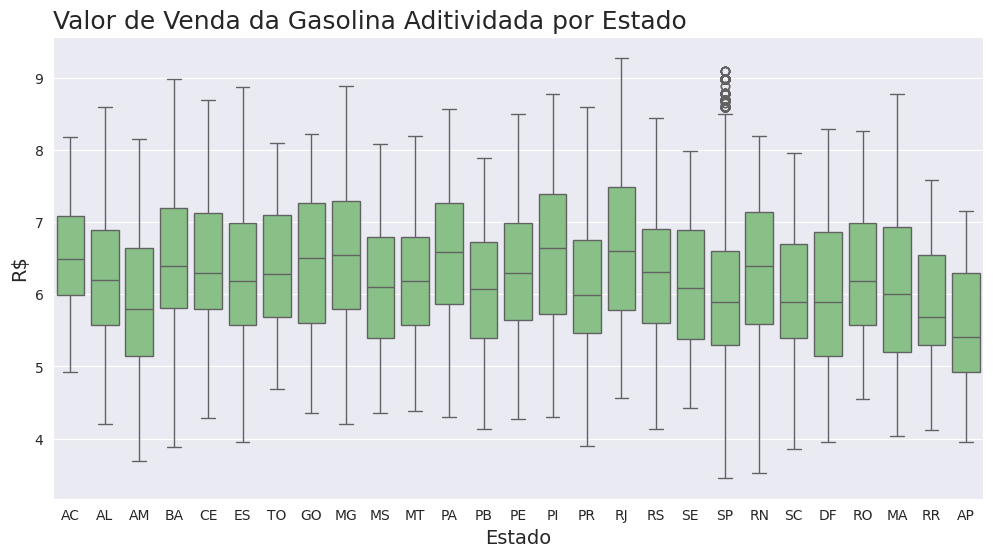

In [21]:
create_boxplot('Valor de Venda da Gasolina Aditividada por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_gasolina_a)

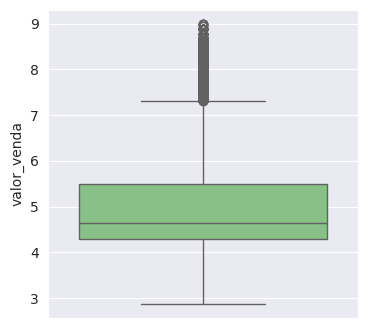

In [22]:
create_boxplot_simple('valor_venda', df_gasolina_c)

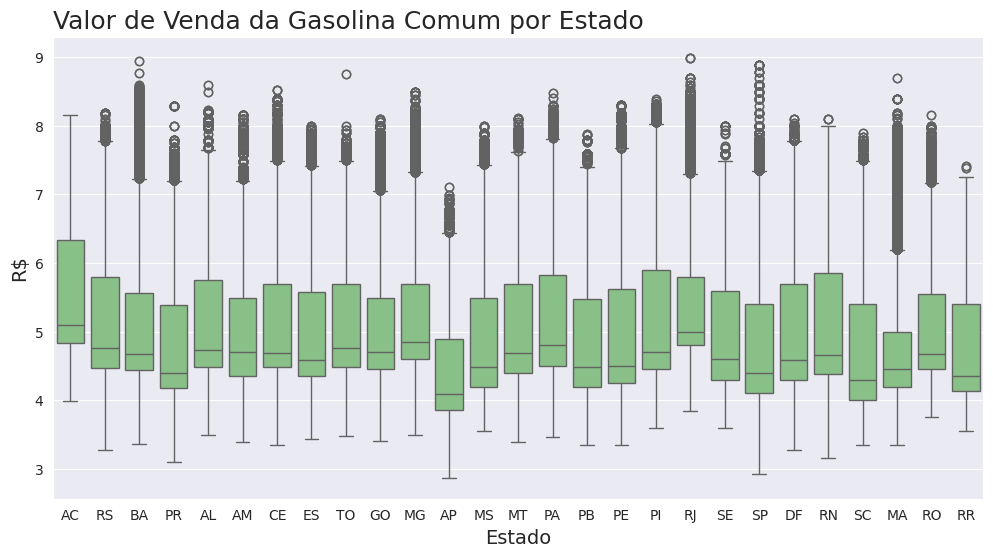

In [23]:
create_boxplot('Valor de Venda da Gasolina Comum por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_gasolina_c)

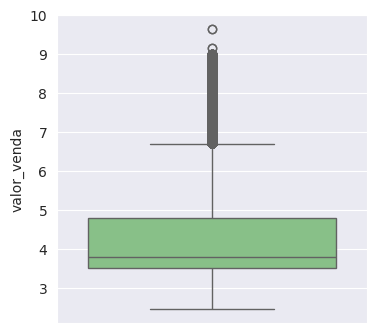

In [24]:
create_boxplot_simple('valor_venda', df_diesel_s10)

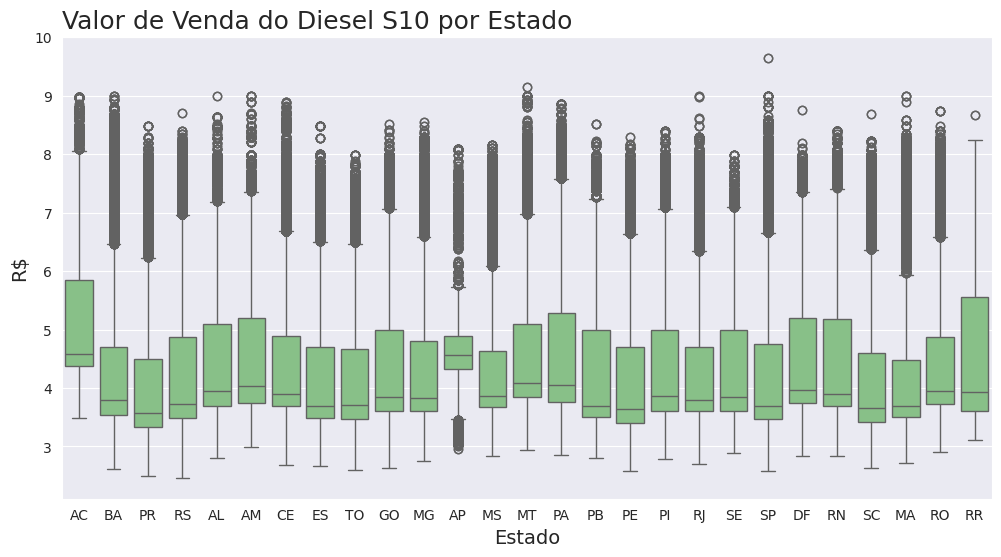

In [25]:
create_boxplot('Valor de Venda do Diesel S10 por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_diesel_s10)

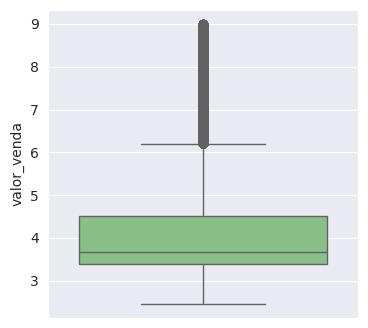

In [26]:
create_boxplot_simple('valor_venda', df_diesel)

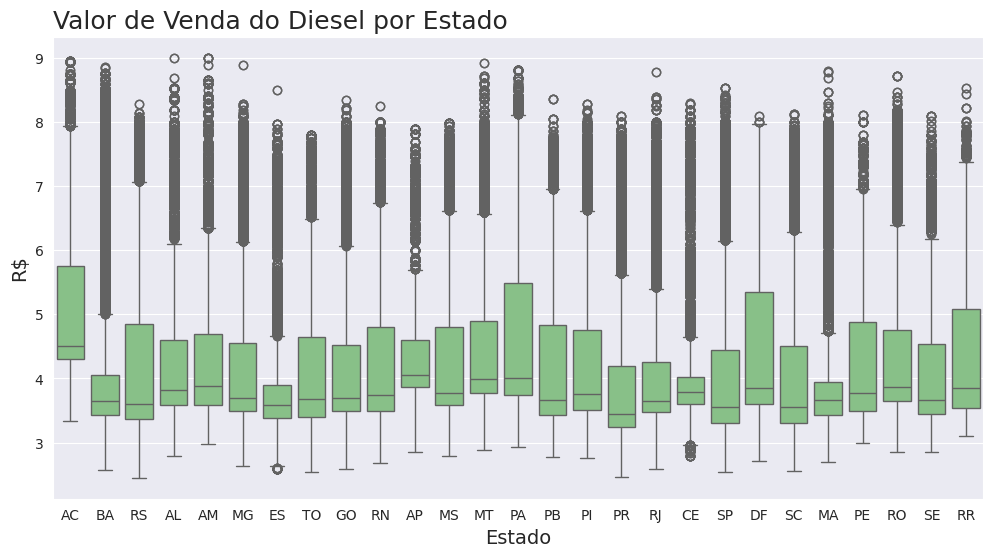

In [27]:
create_boxplot('Valor de Venda do Diesel por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_diesel)

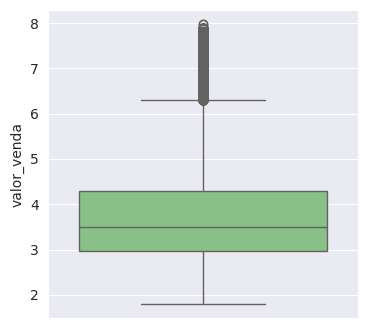

In [28]:
create_boxplot_simple('valor_venda', df_etanol)

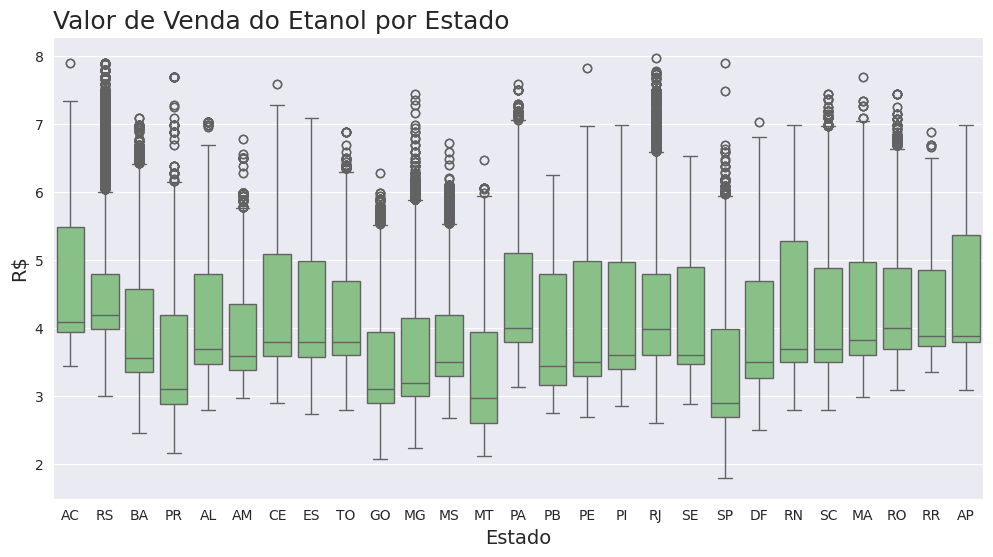

In [29]:
create_boxplot('Valor de Venda do Etanol por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_etanol)

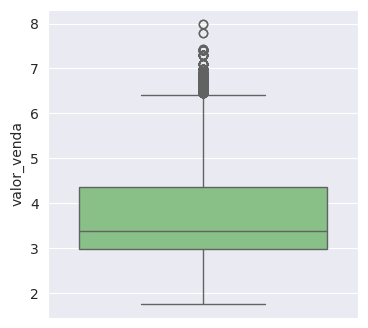

In [30]:
create_boxplot_simple('valor_venda', df_gnv)

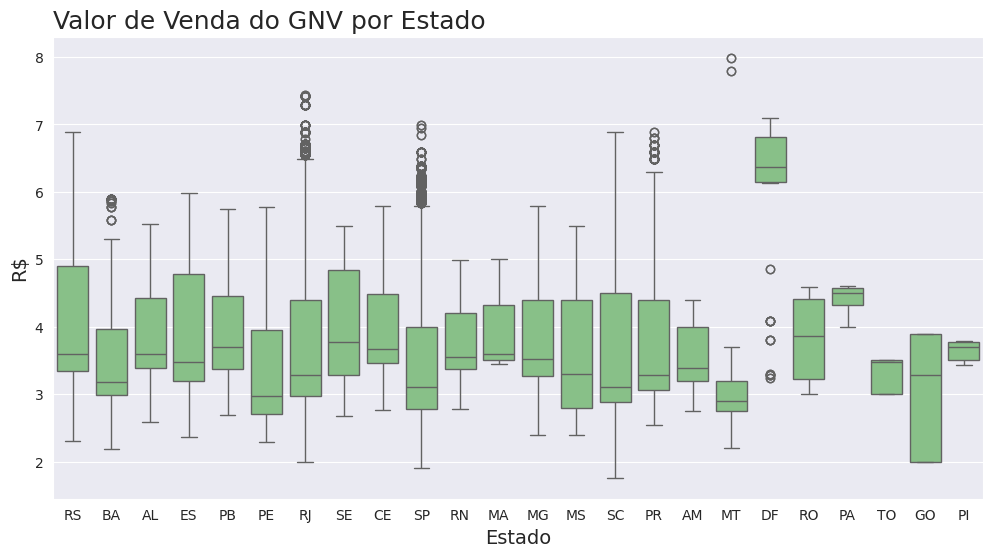

In [31]:
create_boxplot('Valor de Venda do GNV por Estado',
               'Estado', 'R$',
               'estado', 'valor_venda',
               df_gnv)

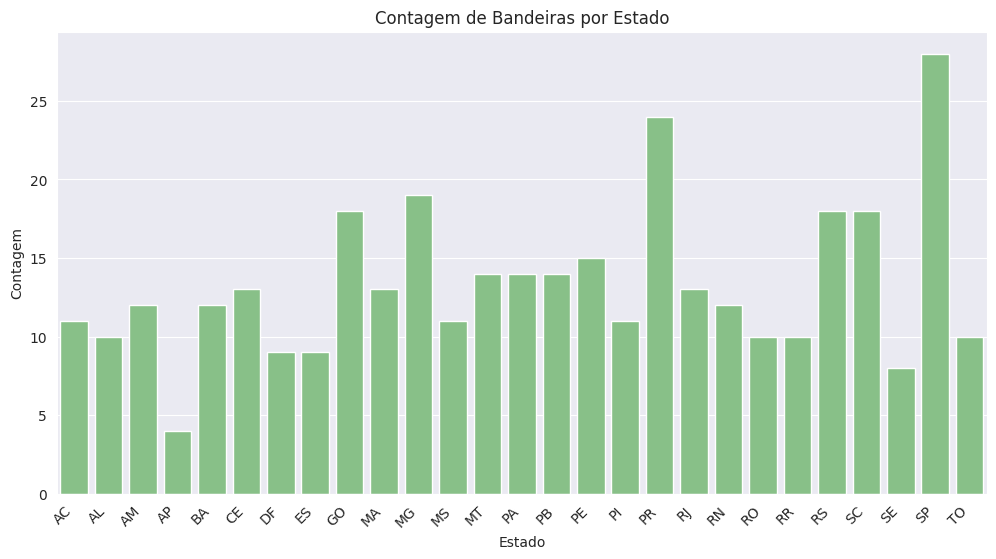

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='estado', y='bandeira',
            data=df[['bandeira', 'estado']].groupby('estado') \
                                           .bandeira.nunique().reset_index())
plt.title('Contagem de Bandeiras por Estado')
plt.xlabel('Estado')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.show()